In [1]:
import os, sys
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from typing import Sequence
from time import perf_counter

%matplotlib inline

In [2]:
path = os.path.abspath('..')
sys.path.append(path)

In [3]:
from qubitrbm.qaoa import QAOA

This is using the GitHub repository available [here](https://github.com/Matematija/QubitRBM) which uses results from this [paper](https://arxiv.org/pdf/2009.01760.pdf) 

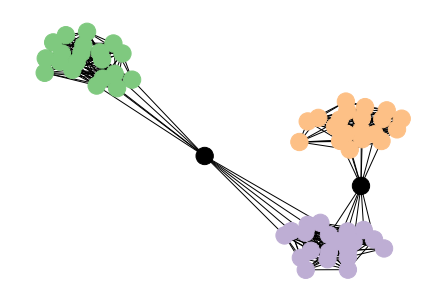

In [4]:
import pennylane as qml
from pennylane import numpy as np

from utils import clustered_chain_graph, get_qaoa_circuit, plot_clustered_chain_graph

r = 3  # number of clusters
n = 20  # nodes in clusters
k = 1  # vertex separators

q1 = 0.7
q2 = 0.3

seed = 1967

layers = 1

G, cluster_nodes, separator_nodes = clustered_chain_graph(n, r, k, q1, q2, seed=seed)
plot_clustered_chain_graph(G)

In [5]:
qaoa = QAOA(G)

We have an anayltic expression for finding the exact costs for $p=1$, this can be used to create a cost landscape for a range of angles.

In [6]:
def plot_landscape(graph, gamma_lims=(0, np.pi/2), beta_lims=(-np.pi/4, np.pi/4), npts=300, figsize=(8,8), ax=None, cmap='plasma'):

    gammas = np.linspace(*gamma_lims, npts)
    betas = np.linspace(*beta_lims, npts)
    G, B = np.meshgrid(gammas, betas)

    cost_grid = QAOA(graph, p=1).exact_cost(G, B)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    m = ax.imshow(cost_grid[::-1,:], cmap=cmap, extent=gamma_lims+beta_lims)

    ax.set_xlabel(r'$\gamma $', fontsize=30)
    ax.set_ylabel(r'$\beta $', rotation=90, fontsize=30)

    cb = fig.colorbar(m, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label(r'$\langle \mathcal{C} \rangle $', fontsize=30)

    return fig, ax

(<Figure size 576x576 with 2 Axes>,
 <AxesSubplot:xlabel='$\\gamma $', ylabel='$\\beta $'>)

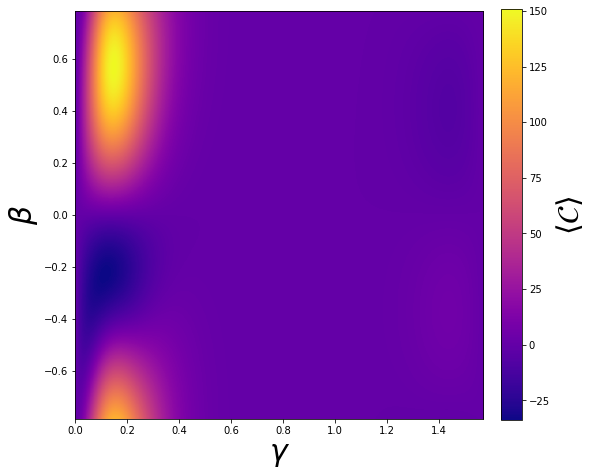

In [7]:
plot_landscape(G)

In [8]:
def optimize_gd(qaoa: QAOA, learning_rate: float, n_iters: int, initial_angles: Sequence[float], verbose: bool = False):

    costs = []
    clock = perf_counter()

    angles = initial_angles

    for i in range(n_iters):

        cost = qaoa.exact_cost(*angles)
        costs.append(cost)

        grads = qaoa.exact_grad_cost(*angles)
        angles -= learning_rate * grads

        if verbose and perf_counter() - clock > 10:
            print(f'Iteration {i+1} | Cost {cost:.4f}')

    return angles, costs

In [9]:
angles = [0.15, 0.2] # = [gamma, beta]

In [10]:
qaoa.exact_cost(*angles)

67.93511211531828

We now find each cost value for varying angles during optimisation

In [11]:
n_iters = 50
learning_rate = 0.0001

In [12]:
%%time
angles, costs = optimize_gd(qaoa, learning_rate, n_iters, angles)

CPU times: user 325 ms, sys: 683 µs, total: 326 ms
Wall time: 325 ms


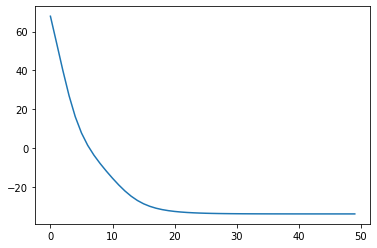

In [13]:
plt.plot(costs)

The final cost value is given by:

In [14]:
costs[-1]

-33.951698911645906

In [15]:
angles.shape

(2,)

In [16]:
gamma_opt, beta_opt = angles

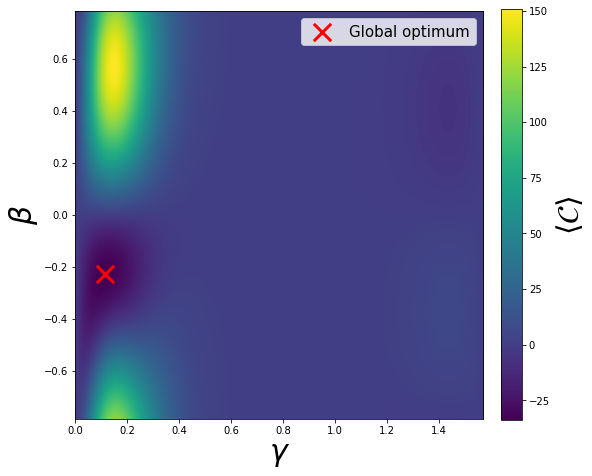

In [17]:
fig, ax = plot_landscape(G, cmap='viridis')
ax.scatter([gamma_opt], [beta_opt], marker='x', c='red', s=300, lw=3, label='Global optimum', zorder=10)
ax.legend(frameon=True, fontsize=15)

We can see we have found the global minimum. We can write the cost values to disk and use them as a target for further numerical simulations.

In [18]:
# import pickle

# with open("./data/analytic_cost", "wb") as fp:
#     pickle.dump(costs, fp)